<a href="https://colab.research.google.com/github/marcochisci/Anomaly_detection/blob/main/2days_AnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airqino table Data
Average data values (every day) of every month since July to predict the anomalies in the last 72 days of the selected data

In [ ]:
import pandas as pd
import psycopg2
import pytz
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import numpy as np
%matplotlib inline


conn = psycopg2.connect(host='playground.magentalab.it', port='45432', database='airqino', user='datareader', password='homntLZnlhQd9prtVA9SFezQek')

query=""" select time_bucket('2 day', c."Dates" ) as "bucket", avg(c."O3") as "O3" ,  avg(c."PM2.5") as "PM2.5", avg(c."CO2") as "CO2",
 avg(c."Temp. int.") as "Temp. int.",  avg(c."T") as "T",  avg(c."PM10") as "PM10", avg(c."RH") as "RH", avg(c."NO2") as 
 "NO2", avg(c."CO") as "CO", avg(c."VOC") as "VOC"
from (select * from crosstab(
  'select sd.data_acquired as timestamp, s.sensor_type ,  sd.float_value as value 
from station_data sd join sensor s on s.id = sd.sensor_id
where sd.data_acquired >= to_timestamp(''2021-06-01 00:00:00'', ''YYYY-mm-dd HH24:MI:SS'')
 and sd.data_acquired <= to_timestamp(''2021-12-10 00:00:00'', ''YYYY-mm-dd HH24:MI:SS'')
and sd.station_id = 23284701 order by sd.data_acquired asc, 1'
 , $$VALUES ('O3'::varchar), ('PM2.5'::varchar), ('CO2'::varchar), ('Temp. int.'::varchar), ('T'::varchar)
 , ('PM10'::varchar), ('RH'::varchar), ('NO2'::varchar), ('CO'::varchar), ('VOC'::varchar)$$
) AS value ("Dates" timestamp, "O3" float, "PM2.5" float, "CO2" float, "Temp. int." float, "T" float, "PM10" float,
"RH" float, "NO2" float, "CO" float, "VOC" float))  c 
group by bucket
order by bucket asc;
 """
df = pd.read_sql(query, conn)
df= df.rename(columns={'bucket': 'Dates'})
df=df.set_index('Dates')
europe = pytz.timezone('Europe/Rome')
df.index = df.index.tz_localize(pytz.utc).tz_convert(europe)
#make the dates a string
df.reset_index(level=0, inplace=True)
for i in range(len(df)):
  df['Dates'][i]=df['Dates'][i].strftime('%Y-%m-%d %H')
df=df.set_index('Dates')
#fix temp int
df['Temp. int.'] = df['Temp. int.'].div(100)
df['T'] = df['T'].div(10)
df=df.dropna()


display(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,
2021-06-29 02,414.139124,1.624904,407.606457,41.741991,27.147118,8.460415,472.916218,239.098386,218.820138,365.710992
2021-07-01 02,400.342587,2.027760,415.258044,38.403817,24.483091,9.625868,569.734385,246.443533,224.645426,348.337539
2021-07-03 02,404.133953,2.320394,412.656096,38.517080,24.875779,6.835429,625.674686,240.383270,236.368507,351.463641
2021-07-05 02,443.333516,1.921429,413.050000,40.398819,26.760604,5.271429,570.756044,294.324176,232.987363,374.687363
2021-07-07 02,491.493747,1.576944,417.467645,41.657890,28.153072,5.341490,545.420881,329.093529,243.160957,392.186514
...,...,...,...,...,...,...,...,...,...,...
2021-11-30 01,450.269273,20.234528,481.348534,17.356167,5.401900,28.479913,868.085776,215.231813,203.695983,338.178610
2021-12-02 01,209.816578,7.496257,442.479679,19.912241,8.303797,10.580749,856.706952,105.476471,216.744385,292.002674
2021-12-04 01,303.865456,14.785371,451.300587,18.372579,6.352376,21.945008,920.329952,152.716498,220.213561,312.499199


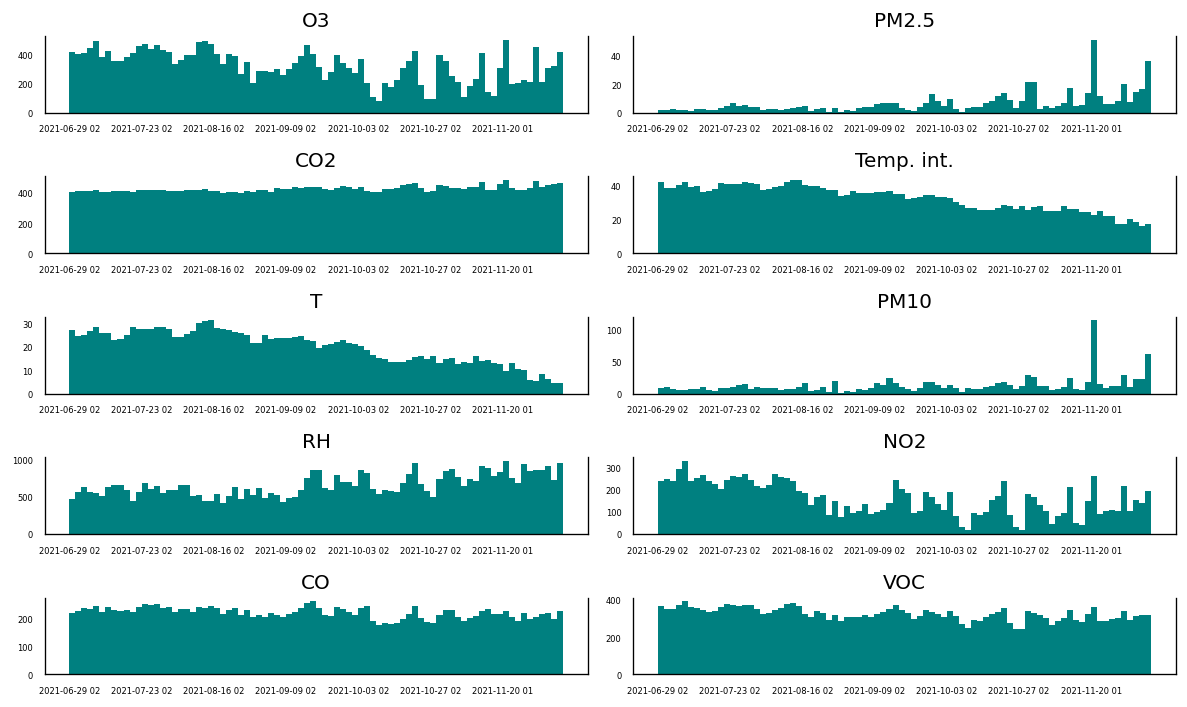

In [ ]:
# Plot
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
x_ticks = np.arange(0, len(df), 12)
plt.setp(axes, xticks=x_ticks)
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.bar(data.index, data, color='teal', align='edge', width=1.0)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=5)
    ax.set_xticks(x_ticks)


plt.tight_layout();

# Testing stationarity 

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]                   
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

adf_test_results = {
    col: test_stationarity(df, col)
    for col in df.columns
}
adf_test_results     

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


{'CO': 'Stationary',
 'CO2': 'Non-Stationary',
 'NO2': 'Non-Stationary',
 'O3': 'Non-Stationary',
 'PM10': 'Stationary',
 'PM2.5': 'Non-Stationary',
 'RH': 'Non-Stationary',
 'T': 'Non-Stationary',
 'Temp. int.': 'Non-Stationary',
 'VOC': 'Stationary'}

Converting to stationary with differencing

In [ ]:
#before the first differencing
df_copy= df.copy()
df_d=df.copy()

In [ ]:
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data
for col in df.columns:
    df[col] = differencing(df, col, 1)

Test for stationarity now

In [ ]:
pip install fitter


     |████████████████████████████████| 47 kB 3.6 MB/s 
  Created wheel for fitter: filename=fitter-1.4.0-py3-none-any.whl size=25025 sha256=1e70296634ef875504db2ae8970ef19c1f6482d5627c2f412fae9eb171cce027
  Stored in directory: /root/.cache/pip/wheels/e1/98/16/e5263962f94fbfaad79902aa94652516caccc1f1d51509e853
  Created wheel for easydev: filename=easydev-0.12.0-py3-none-any.whl size=64232 sha256=ae5bc3cf8a1edb525057d781757ad078934f5f91dc8634676cc0ac36b28f7a1b
  Stored in directory: /root/.cache/pip/wheels/82/ab/83/fdfc4017ea44a585b6754752cc5f63f2d0d63fcc1317e7174b
Successfully built fitter easydev


# Searching the anomalies using the euclidian distance for each variable

Use this after you checked stationarity

In [ ]:
from statsmodels.tsa.api import VAR
max_lag = 6
var_model = VAR(df)
# select the best lag order
lag_results = var_model.select_order(max_lag)
selected_lag_eucl = lag_results.aic
print(selected_lag_eucl)

6


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
import numpy as np
import scipy as sp

#euclidian distance
def euclidian(x=None, data=None):
  distance = pd.DataFrame(index=df_copy.index[selected_lag_eucl:], columns=data.columns)
  for col in data.columns:
    distance[col]=abs((x[col]).values-(data[col]).values)
  return distance
var = VAR(df)
var_fitresults = var.fit(selected_lag_eucl)
var_summaryeucl=str(var_fitresults.summary())
print(var_summaryeucl[0:624])
var_fit_df=pd.DataFrame(var_fitresults.fittedvalues, index=df_copy.index[selected_lag_eucl:], columns=df.columns)
distance = euclidian(x=var_fit_df, data= df.iloc[selected_lag_eucl:])
display(distance)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 09, Jan, 2022
Time:                     11:14:31
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    46.4069
Nobs:                     76.0000    HQIC:                   35.1760
Log likelihood:          -1520.98    FPE:                4.61895e+14
AIC:                      27.6997    Det(Omega_mle):     1.27489e+12
--------------------------------------------------------------------



,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,
2021-07-11 02,21.892195,2.184357,2.186197,0.255774,0.345138,5.744349,40.642713,19.479587,3.230025,4.123032
2021-07-13 02,6.371017,1.613527,3.071768,0.918385,1.066334,5.994583,72.335625,19.454997,4.888297,1.665022
2021-07-15 02,27.078140,0.999336,1.578009,0.195101,0.329368,3.497477,35.598244,18.708168,3.156521,8.103317
2021-07-17 02,47.995917,2.144585,7.178946,0.666963,0.486119,6.193018,39.209429,32.954113,3.190471,10.206970
2021-07-19 02,7.731287,3.037282,2.384689,0.208807,0.207463,7.000008,5.115691,4.814288,0.978245,0.147057
...,...,...,...,...,...,...,...,...,...,...
2021-11-30 01,0.776192,0.812725,0.991278,0.265882,0.231832,1.790614,2.525207,0.496996,1.302209,2.256854
2021-12-02 01,12.572767,1.097780,2.804298,0.020119,0.019501,2.120864,11.939343,8.138380,0.619948,3.513233
2021-12-04 01,16.632033,0.143852,2.021152,0.545762,0.487285,0.531726,5.293788,6.319537,1.408733,5.743191


# Distributions function code

In [ ]:
from scipy.stats import burr, beta, expon, norm, uniform, weibull_min, weibull_max, invgauss, gamma, lognorm, pearson3, triang
import matplotlib.pyplot as plt



Get how many variables the distribution needs to work correctly

In [ ]:
def get_num_var(distribution):
  if(distribution=='burr' or distribution=='beta'):
    num_var=2
  if(distribution=='invgauss' or distribution=='gamma' or distribution=='weibull_min' or distribution=='weibull_max' or distribution=='lognorm'
         or distribution=='pearson3' or distribution=='triang' ):
    num_var=1
  if(distribution=='expon' or distribution=='norm' or distribution=='uniform' ):
    num_var=0
  return num_var

In [ ]:
#distributions, convert from string to dis
distributions={"burr": burr, "beta": beta, "invgauss": invgauss, "gamma": gamma, "weibull_min": weibull_min, "weibull_max": weibull_max,
               "lognorm": lognorm, "pearson3": pearson3, "triang": triang, "expon": expon, "norm": norm, "uniform": uniform}

Function used to get the thresholds

In [ ]:
def get_thresholds(dis, param, min, max,num_var):
  low, med, high=  0.975,0.99,0.995
  find= np.linspace(min+((max-min)/1000),max*2, 2000)
  x = np.linspace(min+((max-min)/1000),max, 1000)
  fig, ax = plt.subplots(1, 1)
  #0 variables
  if(num_var==0):
    loc, scale = param[0], param[1]
    #graph to test if the parameters are correct
    ax.plot(x, dis.pdf(x, loc, scale),
       'r-', lw=5, alpha=0.6)

    # using the cdf
    found=0
    for i in find:
      if ((dis.cdf(i, loc, scale)>low) & (found<1)):
        threshold_l=i
        found=1
      if ((dis.cdf(i, loc, scale)>med) & (found<2)):
        threshold_m=i
        found=2
      if ((dis.cdf(i, loc, scale)>high) & (found<3)):
        threshold_h=i
        found=3
  #1 variables
  if(num_var==1):
    c= param[0]
    loc, scale = param[1], param[2]
    #graph to test if the parameters are correct
    ax.plot(x, dis.pdf(x,c, loc, scale),
       'r-', lw=5, alpha=0.6)

    # using the cdf
    found=0
    for i in find:
      if ((dis.cdf(i, c,loc, scale)>low) & (found<1)):
        threshold_l=i
        found=1
      if ((dis.cdf(i,c, loc, scale)>med) & (found<2)):
        threshold_m=i
        found=2
      if ((dis.cdf(i,c, loc, scale)>high) & (found<3)):
        threshold_h=i
        found=3
  #3 variables
  if(num_var==2):
    c,d= param[0], param[1]
    loc, scale = param[2], param[3]
    #graph to test if the parameters are correct
    ax.plot(x, dis.pdf(x,c,d, loc, scale),
       'r-', lw=5, alpha=0.6)

    # using the cdf
    found=0
    for i in find:
      if ((dis.cdf(i,c,d, loc, scale)>low) & (found<1)):
        threshold_l=i
        found=1
      if ((dis.cdf(i,c,d, loc, scale)>med) & (found<2)):
        threshold_m=i
        found=2
      if ((dis.cdf(i,c,d, loc, scale)>high) & (found<3)):
        threshold_h=i
        found=3
  return threshold_l, threshold_m, threshold_h

# Testing the distance's distributions and finding the thresholds

Make histograms

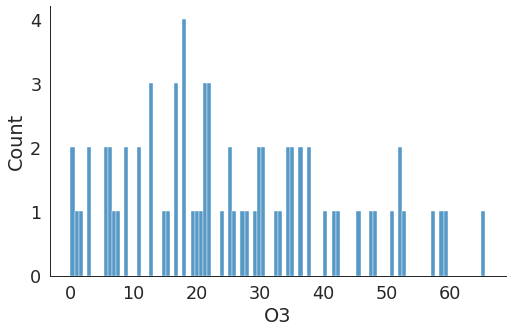

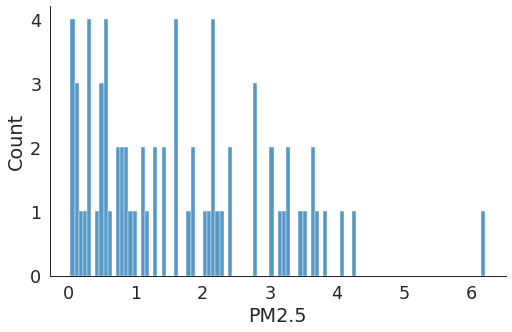

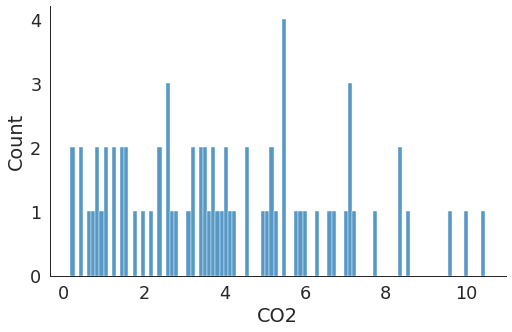

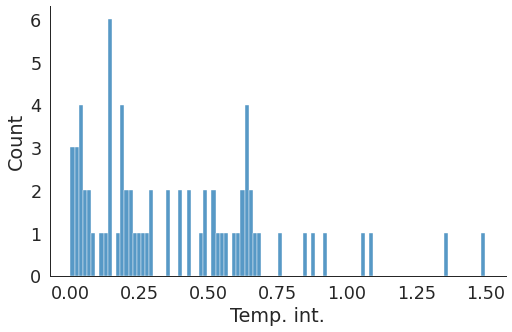

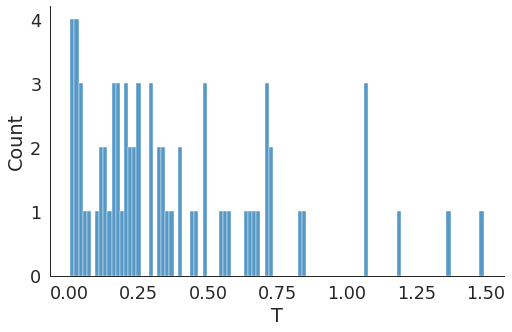

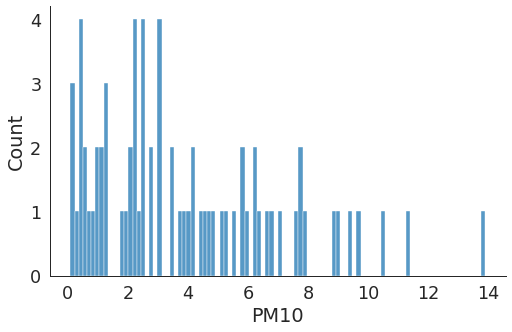

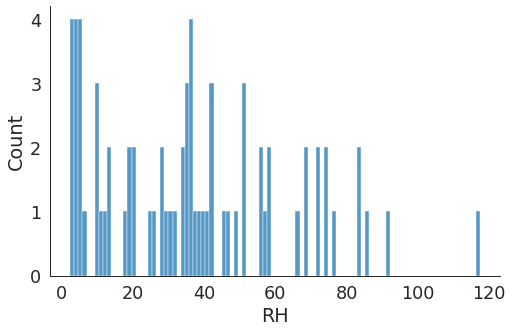

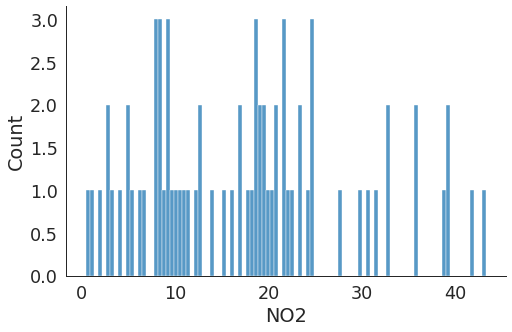

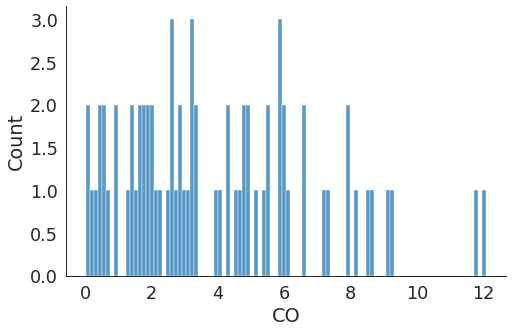

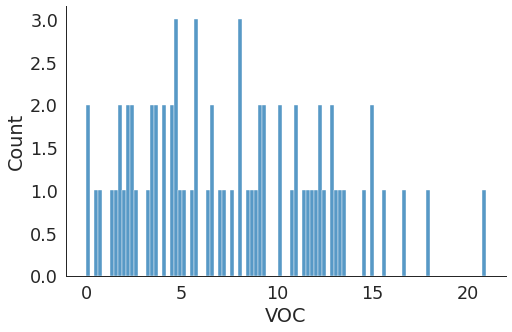

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
import scipy.stats as stats

#remove outliers
z_scores = stats.zscore(distance)

abs_z_scores = np.abs(z_scores)
filtered_distance = (abs_z_scores < 3).all(axis=1)
new_distance = distance[filtered_distance]

for col in df.columns:
  sns.set_style('white')
  sns.set_context("paper", font_scale = 2)
  sns.displot(data=new_distance, x=col, kind="hist", bins = 100, aspect = 1.5)

Find the best distribution (the output ranks the best distributions in ascending order)

          sumsquare_error         aic         bic  kl_div
beta             0.034426  871.620244 -533.378022     inf
gamma            0.034600  896.270572 -537.290361     inf
pearson3         0.034600  896.270682 -537.290356     inf
invgauss         0.034609  898.645975 -537.273118     inf
lognorm          0.034617  899.569842 -537.256061     inf


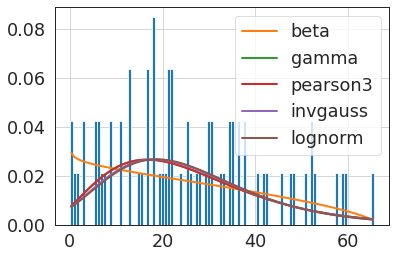

In [ ]:
dis = new_distance["O3"].values
O3_min=min(dis)
O3_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_O=f.fitted_param[distribution]

59.24336104892774 62.324745444923515 63.767095587730054


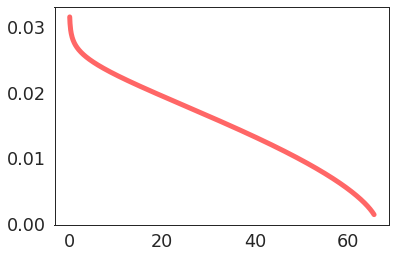

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_O3_l, threshold_O3_m, threshold_O3_h= get_thresholds(dis, param_O, O3_min, O3_max,num_var)
print(threshold_O3_l, threshold_O3_m, threshold_O3_h)


          sumsquare_error         aic         bic  kl_div
burr             4.164033  486.975388 -188.106435     inf
beta             4.176981  478.889279 -187.882914     inf
pearson3         4.212316  482.957382 -191.553059     inf
gamma            4.216641  487.262407 -191.479159     inf
expon            4.225473  479.738807 -195.605175     inf


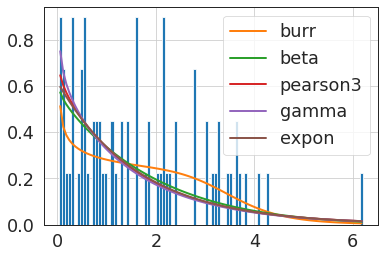

In [ ]:
dis = new_distance["PM2.5"].values
PM2_min=min(dis)
PM2_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_P=f.fitted_param[distribution]

4.721041659835369 5.495437700292284 6.139735205952436


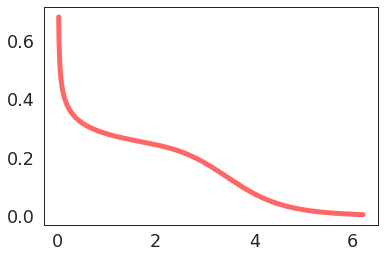

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_PM2_l, threshold_PM2_m, threshold_PM2_h= get_thresholds(dis, param_P, PM2_min, PM2_max,num_var)
print(threshold_PM2_l, threshold_PM2_m, threshold_PM2_h)


          sumsquare_error         aic         bic  kl_div
burr             1.208195  519.561843 -277.196092     inf
triang           1.214041  505.111690 -281.125260     inf
beta             1.217888  502.178670 -276.620792     inf
gamma            1.268017  529.890197 -277.993277     inf
pearson3         1.268017  529.889589 -277.993253     inf


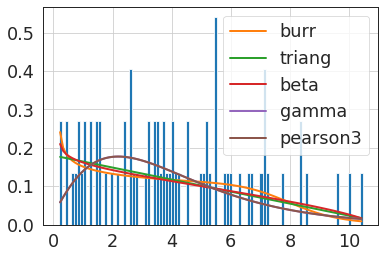

In [ ]:
dis = new_distance["CO2"].values
CO2_min=min(dis)
CO2_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_CO2=f.fitted_param[distribution]

9.329817849102042 10.388838991002084 11.219443808178587


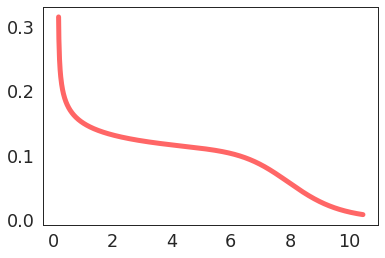

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_CO2_l, threshold_CO2_m, threshold_CO2_h= get_thresholds(dis, param_CO2, CO2_min, CO2_max,num_var)
print(threshold_CO2_l, threshold_CO2_m, threshold_CO2_h)


             sumsquare_error         aic        bic  kl_div
beta               67.867751  207.555409  12.851094     inf
weibull_min        68.100398  200.334529   8.820818     inf
pearson3           68.226408  206.102884   8.953921     inf
expon              68.415554  203.704924   4.876586     inf
gamma              68.579132  210.766574   9.325195     inf


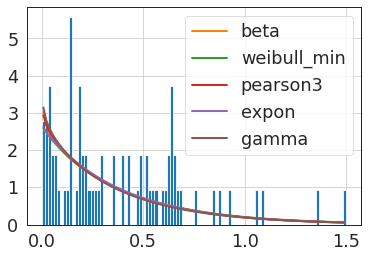

In [ ]:
dis = new_distance["Temp. int."].values
Temp_min=min(dis)
Temp_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_Temp= f.fitted_param[distribution]

1.339212859063285 1.6253296168069042 1.8290567322683295


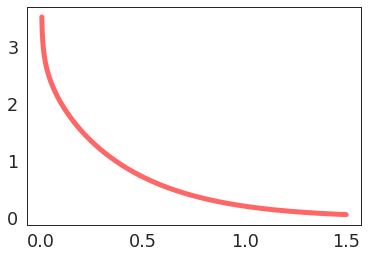

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_Temp_l, threshold_Temp_m, threshold_Temp_h= get_thresholds(dis, param_Temp, Temp_min, Temp_max,num_var)
print(threshold_Temp_l, threshold_Temp_m, threshold_Temp_h)

          sumsquare_error         aic       bic  kl_div
burr            56.756709  216.940737 -0.021578     inf
gamma           58.987768  208.895031 -1.522195     inf
pearson3        59.225419  211.143437 -1.232703     inf
expon           59.617520  202.493931 -5.034265     inf
beta            60.031336  153.356714  4.017106     inf


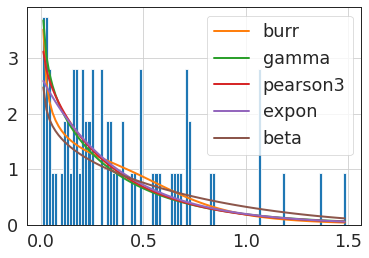

In [ ]:
dis = new_distance["T"].values
T_min=min(dis)
T_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_T=f.fitted_param[distribution]

1.2685990183029368 1.6320663268305529 1.9642516129029235


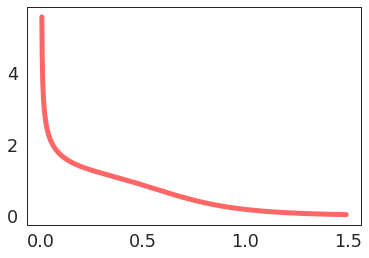

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_T_l, threshold_T_m, threshold_T_h= get_thresholds(dis, param_T, T_min, T_max,num_var)
print(threshold_T_l, threshold_T_m, threshold_T_h)

             sumsquare_error         aic         bic  kl_div
beta                0.673875  615.126941 -319.232460     inf
burr                0.681687  668.562753 -318.402581     inf
expon               0.698413  632.947352 -325.210631     inf
weibull_min         0.703914  634.045377 -320.369094     inf
pearson3            0.704762  634.534617 -320.282426     inf


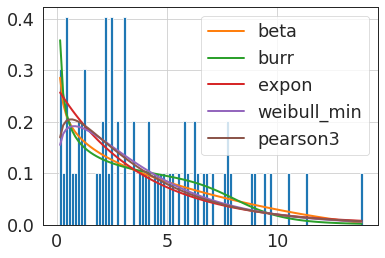

In [ ]:
dis = new_distance["PM10"].values
PM10_min=min(dis)
PM10_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_PM10=f.fitted_param[distribution]

11.430814847354359 12.496391646262232 13.077615354757434


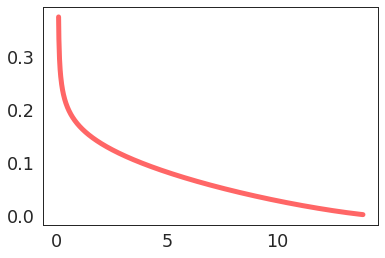

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_PM10_l, threshold_PM10_m, threshold_PM10_h= get_thresholds(dis, param_PM10, PM10_min, PM10_max,num_var)
print(threshold_PM10_l, threshold_PM10_m, threshold_PM10_h)


          sumsquare_error          aic         bic  kl_div
burr             0.011430  1107.771733 -612.764041     inf
beta             0.012504  1043.810907 -606.297142     inf
pearson3         0.012887  1050.479215 -608.397999     inf
gamma            0.012906  1059.441642 -608.293937     inf
expon            0.013047  1046.202486 -611.789709     inf


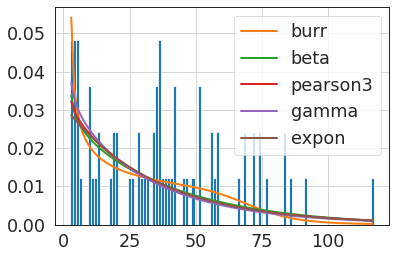

In [ ]:
dis = new_distance["RH"].values
RH_min=min(dis)
RH_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_RH=f.fitted_param[distribution]

83.87433300339558 95.26786239056473 104.45244220267047


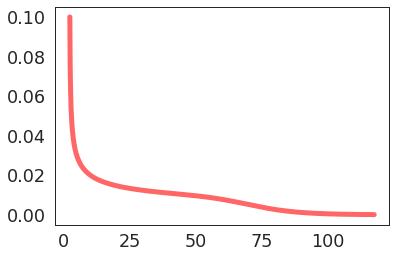

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_RH_l, threshold_RH_m, threshold_RH_h= get_thresholds(dis, param_RH, RH_min, RH_max,num_var)
print(threshold_RH_l, threshold_RH_m, threshold_RH_h)


          sumsquare_error         aic         bic  kl_div
triang           0.073708  788.605539 -482.839848     inf
beta             0.074602  780.164829 -477.695646     inf
burr             0.074791  801.249317 -477.513777     inf
gamma            0.074982  808.215491 -481.606912     inf
pearson3         0.074982  808.215657 -481.606864     inf


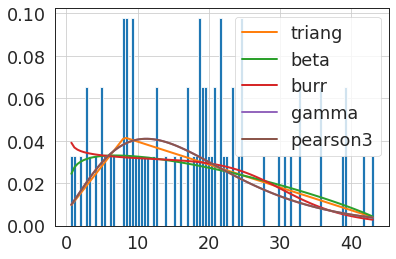

In [ ]:
dis = new_distance["NO2"].values
NO2_min=min(dis)
NO2_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_NO2=f.fitted_param[distribution]

39.84929263825602 42.341047703614485 43.62988653052404


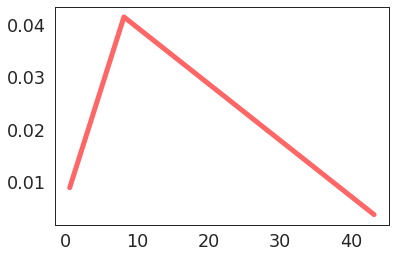

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_NO2_l, threshold_NO2_m, threshold_NO2_h= get_thresholds(dis, param_NO2, NO2_min, NO2_max,num_var)
print(threshold_NO2_l, threshold_NO2_m, threshold_NO2_h)

             sumsquare_error         aic         bic  kl_div
burr                0.730853  592.536678 -313.388401     inf
triang              0.739752  544.022144 -316.793688     inf
beta                0.741659  562.431547 -312.331640     inf
weibull_min         0.749764  578.852665 -315.825721     inf
pearson3            0.760785  581.601030 -314.775101     inf


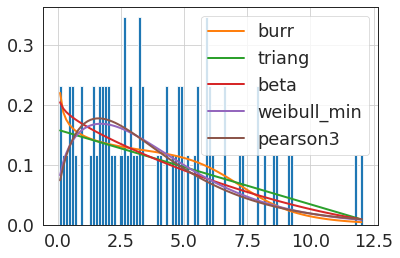

In [ ]:
dis = new_distance["CO"].values
CO_min=min(dis)
CO_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_CO=f.fitted_param[distribution]

9.866417986828681 11.470978893673225 12.785994975222513


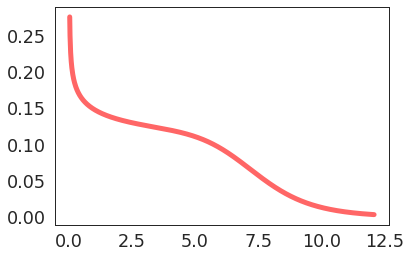

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_CO_l, threshold_CO_m, threshold_CO_h= get_thresholds(dis, param_CO, CO_min, CO_max,num_var)
print(threshold_CO_l, threshold_CO_m, threshold_CO_h)

             sumsquare_error         aic         bic  kl_div
burr                0.249412  689.762340 -390.795920     inf
beta                0.252509  662.785042 -389.907609     inf
triang              0.252939  654.613504 -394.061585     inf
weibull_min         0.258774  675.403061 -392.419616     inf
gamma               0.262521  678.757286 -391.384381     inf


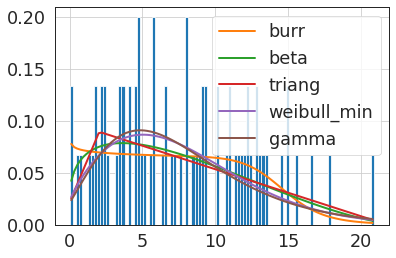

In [ ]:
dis = new_distance["VOC"].values
VOC_min=min(dis)
VOC_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_VOC=f.fitted_param[distribution]

16.758896277002048 18.47357775802616 19.811865743215712


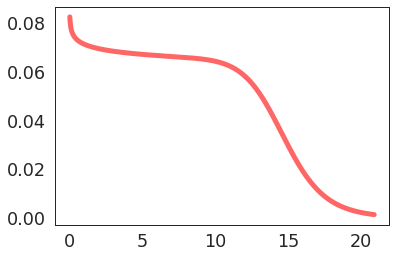

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_VOC_l, threshold_VOC_m, threshold_VOC_h= get_thresholds(dis, param_VOC, VOC_min, VOC_max,num_var)
print(threshold_VOC_l, threshold_VOC_m, threshold_VOC_h)


# Using the thresholds to search anomalies 

In [ ]:
def find_anomalies_thresholds(errors, threshold_low, threshold_med, threshold_high):
  predictions=pd.DataFrame(np.zeros((len(errors), 1)))
  for i in range(len(errors)):
    if((errors.iloc[i] >= threshold_low) &(errors.iloc[i] < threshold_med)):
      predictions.iloc[i]=1
    if((errors.iloc[i] >= threshold_med) &(errors.iloc[i]< threshold_high)):
      predictions.iloc[i]=2
    if(errors.iloc[i] >= threshold_high):
      predictions.iloc[i]=3
  return predictions

to_show=48
data_thresh=df_copy.iloc[-to_show:,:]

Finding anomalies with the burr distribution (O3)

In [ ]:
predictions_O3 = find_anomalies_thresholds(distance['O3'], threshold_O3_l, threshold_O3_m, threshold_O3_h)

data_thresh['Predictions_O3'] = predictions_O3.iloc[-to_show:,:].values
data_thresh['Predictions_O3'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    46
3.0     2
Name: Predictions_O3, dtype: int64

Finding anomalies with the burr distribution (PM2.5)

In [ ]:
predictions_PM2 = find_anomalies_thresholds(distance['PM2.5'], threshold_PM2_l, threshold_PM2_m, threshold_PM2_h)

data_thresh['Predictions_PM2.5'] = predictions_PM2.iloc[-to_show:,:].values
data_thresh['Predictions_PM2.5'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    46
3.0     2
Name: Predictions_PM2.5, dtype: int64

Finding anomalies with the burr distribution (CO2)

In [ ]:
predictions_CO2 = find_anomalies_thresholds(distance['CO2'], threshold_CO2_l, threshold_CO2_m, threshold_CO2_h)

data_thresh['Predictions_CO2'] = predictions_CO2.iloc[-to_show:,:].values
data_thresh['Predictions_CO2'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    46
3.0     1
1.0     1
Name: Predictions_CO2, dtype: int64

Finding anomalies with the beta distribution (Temp. int.)

In [ ]:
predictions_Temp = find_anomalies_thresholds(distance['Temp. int.'], threshold_Temp_l, threshold_Temp_m, threshold_Temp_h)

data_thresh['Predictions_Temp_int'] = predictions_Temp.iloc[-to_show:,:].values
data_thresh['Predictions_Temp_int'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    48
Name: Predictions_Temp_int, dtype: int64

Finding anomalies with the burr distribution (T)


In [ ]:
predictions_T = find_anomalies_thresholds(distance['T'], threshold_T_l, threshold_T_m, threshold_T_h)

data_thresh['Predictions_T'] = predictions_T.iloc[-to_show:,:].values
data_thresh['Predictions_T'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    48
Name: Predictions_T, dtype: int64

Finding anomalies with the burr distribution (PM10)

In [ ]:
predictions_PM10 = find_anomalies_thresholds(distance['PM10'], threshold_PM10_l, threshold_PM10_m, threshold_PM10_h)

data_thresh['Predictions_PM10'] = predictions_PM10.iloc[-to_show:,:].values
data_thresh['Predictions_PM10'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    46
3.0     2
Name: Predictions_PM10, dtype: int64

Finding anomalies with the burr distribution (RH)

In [ ]:
predictions_RH = find_anomalies_thresholds(distance['RH'], threshold_RH_l, threshold_RH_m, threshold_RH_h)

data_thresh['Predictions_RH'] = predictions_RH.iloc[-to_show:,:].values
data_thresh['Predictions_RH'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    43
1.0     3
2.0     1
3.0     1
Name: Predictions_RH, dtype: int64

Finding anomalies with the burr distribution (NO2)

In [ ]:
predictions_NO2 = find_anomalies_thresholds(distance['NO2'], threshold_NO2_l, threshold_NO2_m, threshold_NO2_h)

data_thresh['Predictions_NO2'] = predictions_NO2.iloc[-to_show:,:].values
data_thresh['Predictions_NO2'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    46
3.0     2
Name: Predictions_NO2, dtype: int64

Finding anomalies with the burr distribution (CO)

In [ ]:
predictions_CO = find_anomalies_thresholds(distance['CO'], threshold_CO_l, threshold_CO_m, threshold_CO_h)

data_thresh['Predictions_CO'] = predictions_CO.iloc[-to_show:,:].values
data_thresh['Predictions_CO'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    45
2.0     2
3.0     1
Name: Predictions_CO, dtype: int64

Finding anomalies with the beta distribution (VOC)

In [ ]:
predictions_VOC = find_anomalies_thresholds(distance['VOC'], threshold_VOC_l, threshold_VOC_m, threshold_VOC_h)

data_thresh['Predictions_VOC'] = predictions_VOC.iloc[-to_show:,:].values
data_thresh['Predictions_VOC'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    46
2.0     1
3.0     1
Name: Predictions_VOC, dtype: int64

# Showing the anomalies found with the euclidian distance with graphs

In [ ]:
show_data_thresh=data_thresh.iloc[-to_show:,:]
day_before= df_copy.iloc[-(to_show*2):-to_show,:]

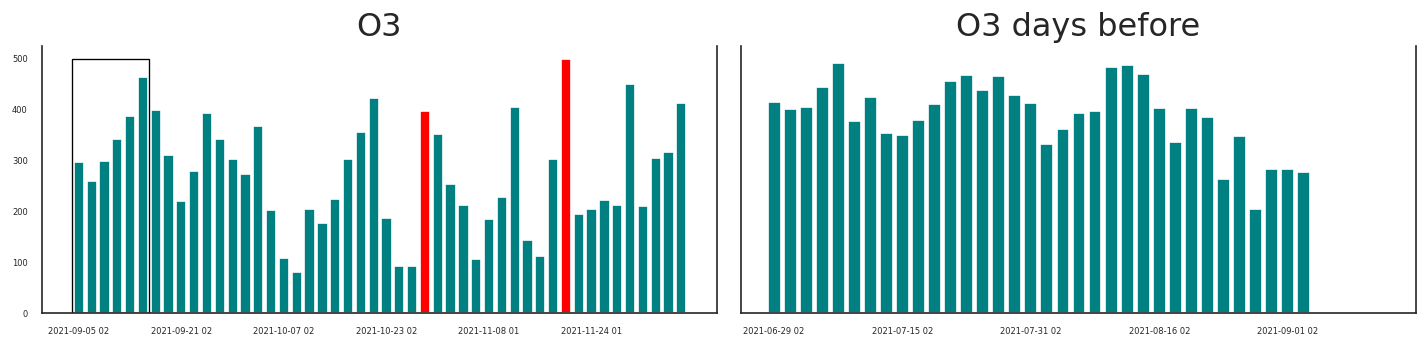

In [ ]:
anomalies_O3_l= show_data_thresh[(data_thresh['Predictions_O3'] == 1)]
anomalies_O3_m= show_data_thresh[(data_thresh['Predictions_O3'] == 2)]
anomalies_O3_h= show_data_thresh[(data_thresh['Predictions_O3'] == 3)]

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, sharey='row', dpi=120, figsize=(12,3))
x_ticks = np.arange(0, to_show, 8)
plt.setp(axes, xticks=x_ticks)
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_O3 = show_data_thresh['O3']
      ax.bar(data_O3.index, data_O3 ,color='teal', linewidth=1)
      ax.set_xticks(x_ticks)    
      # x axis value list.
      x_number_list_l = list(anomalies_O3_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_O3_l['O3'].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_l, y_number_list_l, color='green', linewidth=1)

      # x axis value list.
      x_number_list_m = list(anomalies_O3_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_O3_m['O3'].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_m, y_number_list_m, color='orange', linewidth=1)

      # x axis value list.
      x_number_list_h = list(anomalies_O3_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_O3_h['O3'].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_h, y_number_list_h, color='red', linewidth=1)
      #lag rectangle
      left, bottom, width, height = (-0.5, 0, 1*selected_lag_eucl, int(max(show_data_thresh['O3']+1)))
      ax.add_patch(matplotlib.patches.Rectangle((left,bottom), width, height,fill= None,
                        alpha=1, color="black"))


      # Decorations
      ax.set_title('O3')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)
    else:
      data_before = day_before['O3']
      ax.bar(data_before.index, data_before, color='teal', linewidth=1)
      ax.set_xticks(x_ticks)
      # Decorations
      ax.set_title('O3 days before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)

plt.tight_layout();

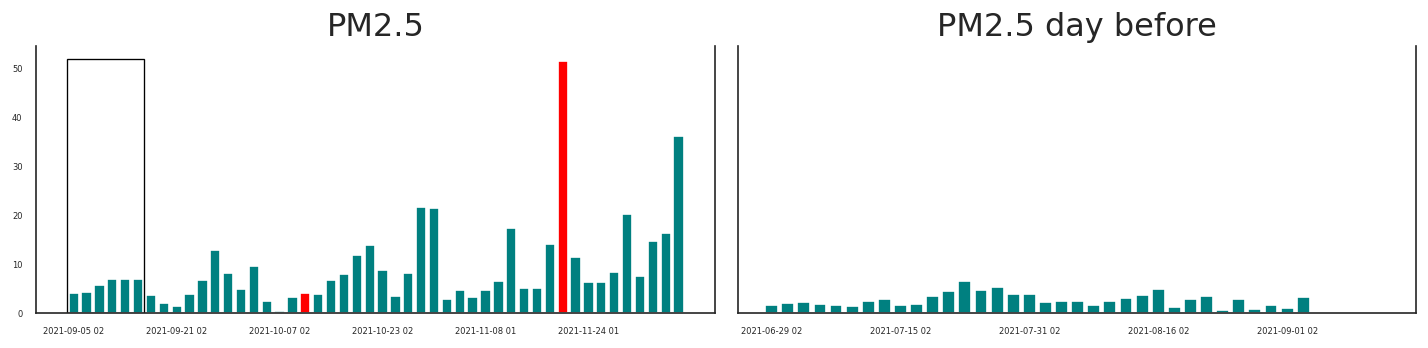

In [ ]:
anomalies_PM2_l= show_data_thresh[(data_thresh['Predictions_PM2.5'] == 1)]
anomalies_PM2_m= show_data_thresh[(data_thresh['Predictions_PM2.5'] == 2)]
anomalies_PM2_h= show_data_thresh[(data_thresh['Predictions_PM2.5'] == 3)]

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, sharey='row', dpi=120, figsize=(12,3))
x_ticks = np.arange(0, to_show, 8)
plt.setp(axes, xticks=x_ticks)
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_PM2 = show_data_thresh['PM2.5']
      ax.bar(data_PM2.index, data_PM2, color='teal', linewidth=1)
      ax.set_xticks(x_ticks) 
          
      # x axis value list.
      x_number_list_l = list(anomalies_PM2_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_PM2_l['PM2.5'].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_l, y_number_list_l, color='green', linewidth=1)

      # x axis value list.
      x_number_list_m = list(anomalies_PM2_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_PM2_m['PM2.5'].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_m, y_number_list_m, color='orange', linewidth=1)

      # x axis value list.
      x_number_list_h = list(anomalies_PM2_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_PM2_h['PM2.5'].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_h, y_number_list_h, color='red', linewidth=1)
      #lag rectangle
      left, bottom, width, height = (-0.5, 0, 1*selected_lag_eucl, int(max(show_data_thresh['PM2.5']+1)))
      ax.add_patch(matplotlib.patches.Rectangle((left,bottom), width, height,fill= None,
                        alpha=1, color="black"))

      # Decorations
      ax.set_title('PM2.5')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)
    else:
      data_before = day_before['PM2.5']
      ax.bar(data_before.index, data_before, color='teal', linewidth=1)
      ax.set_xticks(x_ticks) 
      # Decorations
      ax.set_title('PM2.5 day before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)

plt.tight_layout();

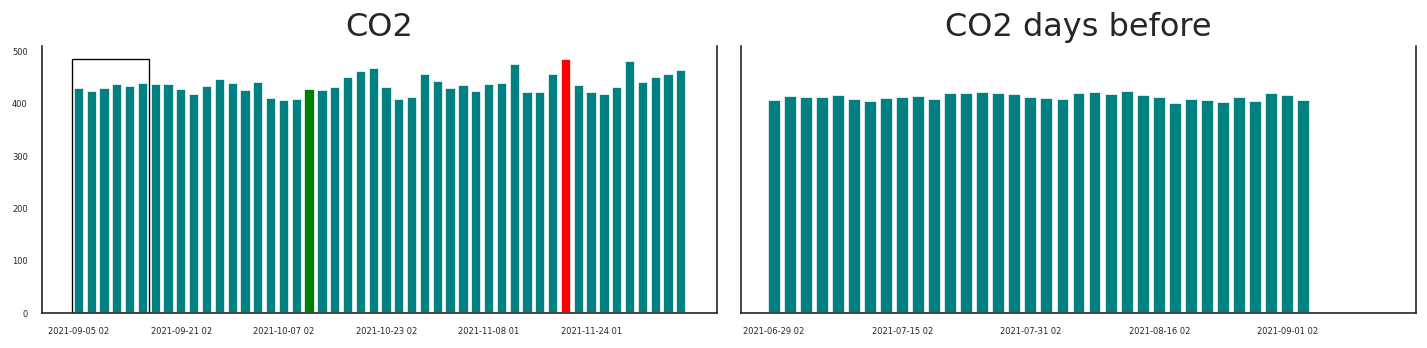

In [ ]:
anomalies_CO2_l= show_data_thresh[(data_thresh['Predictions_CO2'] == 1)]
anomalies_CO2_m= show_data_thresh[(data_thresh['Predictions_CO2'] == 2)]
anomalies_CO2_h= show_data_thresh[(data_thresh['Predictions_CO2'] == 3)]

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, sharey='row', dpi=120, figsize=(12,3))
x_ticks = np.arange(0, to_show, 8)
plt.setp(axes, xticks=x_ticks)
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_CO2 = show_data_thresh['CO2']
      ax.bar(data_CO2.index, data_CO2, color='teal', linewidth=1)
      ax.set_xticks(x_ticks) 
          
      # x axis value list.
      x_number_list_l = list(anomalies_CO2_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_CO2_l['CO2'].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_l, y_number_list_l, color='green', linewidth=1)

      # x axis value list.
      x_number_list_m = list(anomalies_CO2_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_CO2_m['CO2'].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_m, y_number_list_m, color='orange', linewidth=1)

      # x axis value list.
      x_number_list_h = list(anomalies_CO2_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_CO2_h['CO2'].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_h, y_number_list_h, color='red', linewidth=1)
      left, bottom, width, height = (-0.5, 0, 1*selected_lag_eucl, int(max(show_data_thresh['CO2']+1)))
      ax.add_patch(matplotlib.patches.Rectangle((left,bottom), width, height, fill=None,
                        alpha=1, color="black"))

      # Decorations
      ax.set_title('CO2')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)
    else:
      data_before = day_before['CO2']
      ax.bar(data_before.index, data_before, color='teal', linewidth=1)
      ax.set_xticks(x_ticks) 
      # Decorations
      ax.set_title('CO2 days before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)

plt.tight_layout();

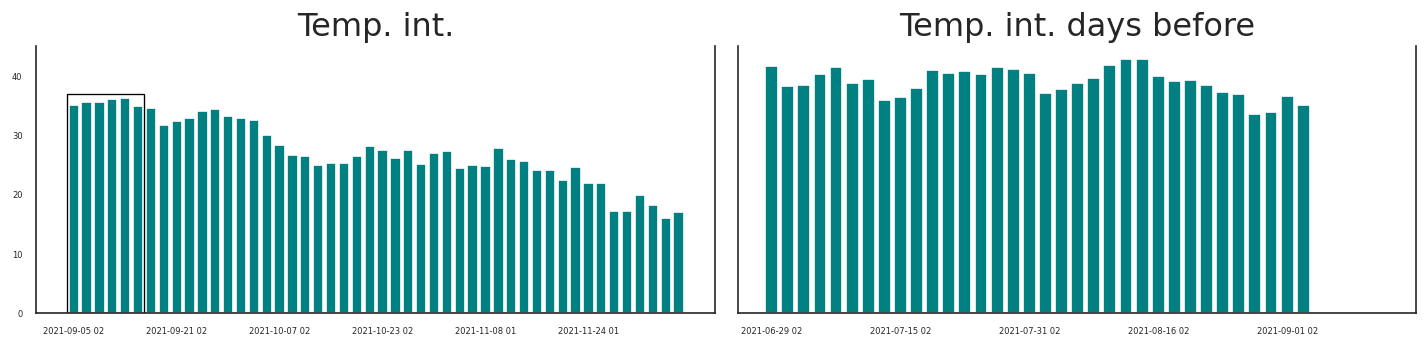

In [ ]:
anomalies_Temp_l= show_data_thresh[(data_thresh['Predictions_Temp_int'] == 1)]
anomalies_Temp_m= show_data_thresh[(data_thresh['Predictions_Temp_int'] == 2)]
anomalies_Temp_h= show_data_thresh[(data_thresh['Predictions_Temp_int'] == 3)]


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2,sharey='row', dpi=120, figsize=(12,3))
x_ticks = np.arange(0, to_show, 8)
plt.setp(axes, xticks=x_ticks)
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_Temp = show_data_thresh['Temp. int.']
      ax.bar(data_Temp.index, data_Temp, color='teal', linewidth=1)
      ax.set_xticks(x_ticks) 
          
      # x axis value list.
      x_number_list_l = list(anomalies_Temp_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_Temp_l['Temp. int.'].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_l, y_number_list_l, color='green', linewidth=1)

      # x axis value list.
      x_number_list_m = list(anomalies_Temp_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_Temp_m['Temp. int.'].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_m, y_number_list_m, color='orange', linewidth=1)

      # x axis value list.
      x_number_list_h = list(anomalies_Temp_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_Temp_h['Temp. int.'].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_h, y_number_list_h, color='red', linewidth=1)
      left, bottom, width, height = (-0.5, 0, 1*selected_lag_eucl, int(max(show_data_thresh['Temp. int.']+1)))
      ax.add_patch(matplotlib.patches.Rectangle((left,bottom), width, height,fill= None,
                        alpha=1, color="black"))

      # Decorations
      ax.set_title('Temp. int.')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)
    else:
      data_before = day_before['Temp. int.']
      ax.bar(data_before.index, data_before, color='teal', linewidth=1)
      ax.set_xticks(x_ticks) 
      # Decorations
      ax.set_title('Temp. int. days before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)

plt.tight_layout();

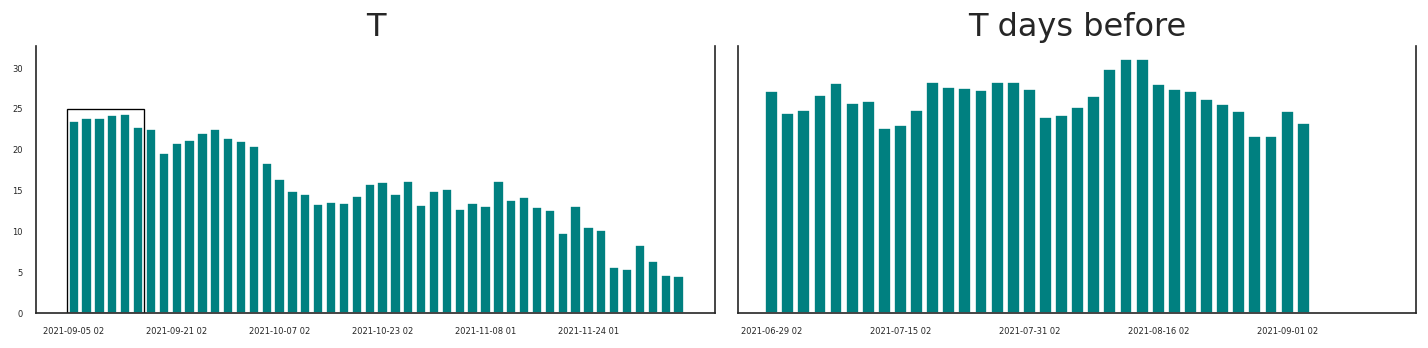

In [ ]:
anomalies_T_l= show_data_thresh[(data_thresh['Predictions_T'] == 1)]
anomalies_T_m= show_data_thresh[(data_thresh['Predictions_T'] == 2)]
anomalies_T_h= show_data_thresh[(data_thresh['Predictions_T'] == 3)]


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, sharey='row', dpi=120, figsize=(12,3))
x_ticks = np.arange(0, to_show, 8)
plt.setp(axes, xticks=x_ticks)
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_T = show_data_thresh['T']
      ax.bar(data_T.index, data_T, color='teal', linewidth=1)
      ax.set_xticks(x_ticks) 
          
      # x axis value list.
      x_number_list_l = list(anomalies_T_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_T_l['T'].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_l, y_number_list_l, color='green', linewidth=1)

      # x axis value list.
      x_number_list_m = list(anomalies_T_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_T_m['T'].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_m, y_number_list_m, color='orange', linewidth=1)

      # x axis value list.
      x_number_list_h = list(anomalies_T_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_T_h['T'].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_h, y_number_list_h, color='red',linewidth=1)
      left, bottom, width, height = (-0.5, 0, 1*selected_lag_eucl, int(max(show_data_thresh['T']+1)))
      ax.add_patch(matplotlib.patches.Rectangle((left,bottom), width, height,fill= None,
                        alpha=1, color="black"))

      # Decorations
      ax.set_title('T')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)
    else:
      data_before = day_before['T']
      ax.bar(data_before.index, data_before, color='teal', linewidth=1)
      ax.set_xticks(x_ticks) 
      # Decorations
      ax.set_title('T days before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)

plt.tight_layout();

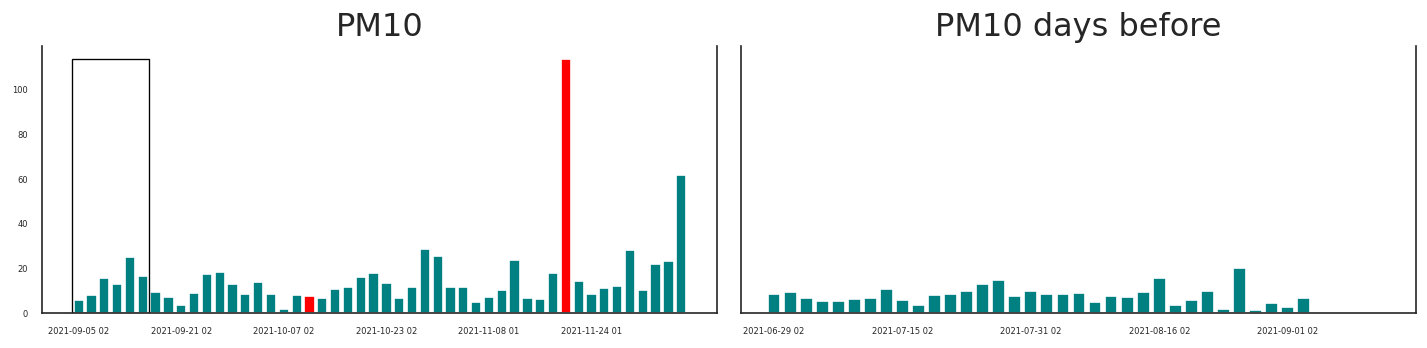

In [ ]:
anomalies_PM10_l= show_data_thresh[(data_thresh['Predictions_PM10'] == 1)]
anomalies_PM10_m= show_data_thresh[(data_thresh['Predictions_PM10'] == 2)]
anomalies_PM10_h= show_data_thresh[(data_thresh['Predictions_PM10'] == 3)]


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, sharey='row', dpi=120, figsize=(12,3))
x_ticks = np.arange(0, to_show, 8)
plt.setp(axes, xticks=x_ticks)
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_PM10 = show_data_thresh['PM10']
      ax.bar(data_PM10.index, data_PM10, color='teal', linewidth=1)
      ax.set_xticks(x_ticks) 
          
      # x axis value list.
      x_number_list_l = list(anomalies_PM10_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_PM10_l['PM10'].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_l, y_number_list_l, color='green',linewidth=1)

      # x axis value list.
      x_number_list_m = list(anomalies_PM10_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_PM10_m['PM10'].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_m, y_number_list_m, color='orange', linewidth=1)

      # x axis value list.
      x_number_list_h = list(anomalies_PM10_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_PM10_h['PM10'].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_h, y_number_list_h, color='red', linewidth=1)
      left, bottom, width, height = (-0.5, 0, 1*selected_lag_eucl, int(max(show_data_thresh['PM10']+1)))
      ax.add_patch(matplotlib.patches.Rectangle((left,bottom), width, height,fill= None,
                        alpha=1, color="black"))

      # Decorations
      ax.set_title('PM10')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)
    else:
      data_before = day_before['PM10']
      ax.bar(data_before.index, data_before, color='teal', linewidth=1)
      ax.set_xticks(x_ticks) 
      # Decorations
      ax.set_title('PM10 days before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)

plt.tight_layout();

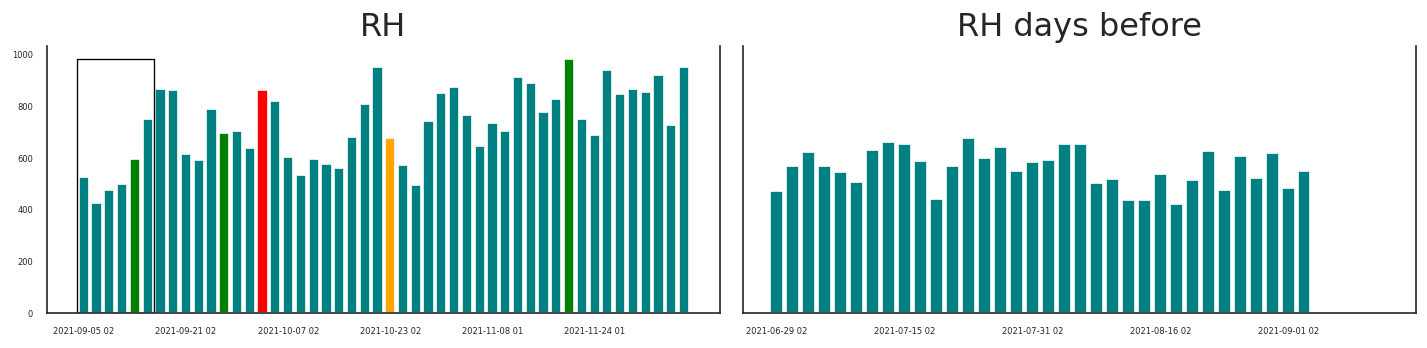

In [ ]:
anomalies_RH_l= show_data_thresh[(data_thresh['Predictions_RH'] == 1)]
anomalies_RH_m= show_data_thresh[(data_thresh['Predictions_RH'] == 2)]
anomalies_RH_h= show_data_thresh[(data_thresh['Predictions_RH'] == 3)]

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, sharey='row', dpi=120, figsize=(12,3))
x_ticks = np.arange(0, to_show, 8)
plt.setp(axes, xticks=x_ticks)
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_RH = show_data_thresh['RH']
      ax.bar(data_RH.index, data_RH, color='teal', linewidth=1)
      ax.set_xticks(x_ticks) 
          
      # x axis value list.
      x_number_list_l = list(anomalies_RH_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_RH_l['RH'].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_l, y_number_list_l, color='green', linewidth=1)

      # x axis value list.
      x_number_list_m = list(anomalies_RH_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_RH_m['RH'].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_m, y_number_list_m, color='orange', linewidth=1)

      # x axis value list.
      x_number_list_h = list(anomalies_RH_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_RH_h['RH'].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_h, y_number_list_h, color='red', linewidth=1)
      left, bottom, width, height = (-0.5, 0, 1*selected_lag_eucl, int(max(show_data_thresh['RH']+1)))
      ax.add_patch(matplotlib.patches.Rectangle((left,bottom), width, height,fill= None,
                        alpha=1, color="black"))

      # Decorations
      ax.set_title('RH')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)
    else:
      data_before = day_before['RH']
      ax.bar(data_before.index, data_before, color='teal', linewidth=1)
      ax.set_xticks(x_ticks) 
      # Decorations
      ax.set_title('RH days before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)

plt.tight_layout();

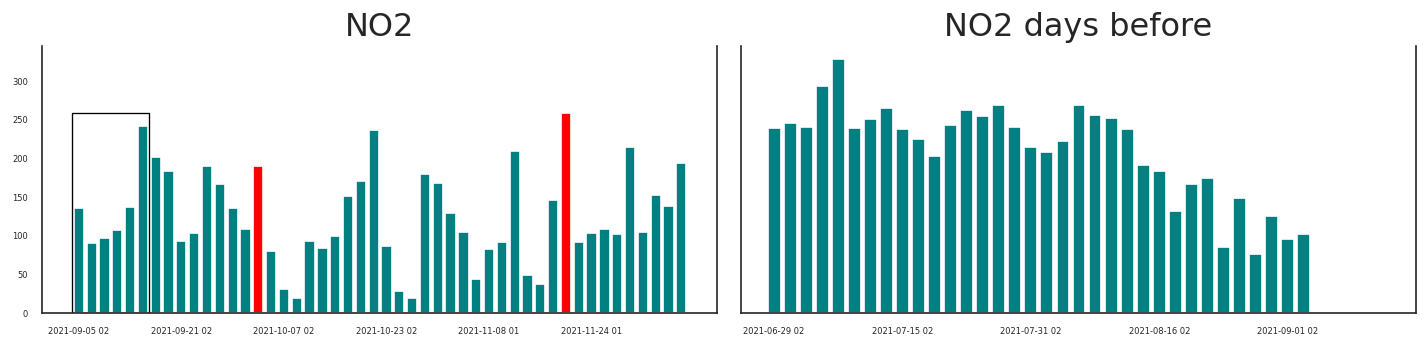

In [ ]:
anomalies_NO2_l= show_data_thresh[(data_thresh['Predictions_NO2'] == 1)]
anomalies_NO2_m= show_data_thresh[(data_thresh['Predictions_NO2'] == 2)]
anomalies_NO2_h= show_data_thresh[(data_thresh['Predictions_NO2'] == 3)]

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, sharey='row', dpi=120, figsize=(12,3))
x_ticks = np.arange(0, to_show, 8)
plt.setp(axes, xticks=x_ticks)
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_NO2 = show_data_thresh['NO2']
      ax.bar(data_NO2.index, data_NO2, color='teal', linewidth=1)
      ax.set_xticks(x_ticks) 
          
      # x axis value list.
      x_number_list_l = list(anomalies_NO2_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_NO2_l['NO2'].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_l, y_number_list_l, color='green', linewidth=1)

      # x axis value list.
      x_number_list_m = list(anomalies_NO2_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_NO2_m['NO2'].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_m, y_number_list_m, color='orange', linewidth=1)

      # x axis value list.
      x_number_list_h = list(anomalies_NO2_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_NO2_h['NO2'].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_h, y_number_list_h, color='red', linewidth=1)
      left, bottom, width, height = (-0.5, 0, 1*selected_lag_eucl, int(max(show_data_thresh['NO2']+1)))
      ax.add_patch(matplotlib.patches.Rectangle((left,bottom), width, height,fill= None,
                        alpha=1, color="black"))


      # Decorations
      ax.set_title('NO2')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)
    else:
      data_before = day_before['NO2']
      ax.bar(data_before.index, data_before, color='teal', linewidth=1)
      ax.set_xticks(x_ticks) 
      # Decorations
      ax.set_title('NO2 days before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)

plt.tight_layout();

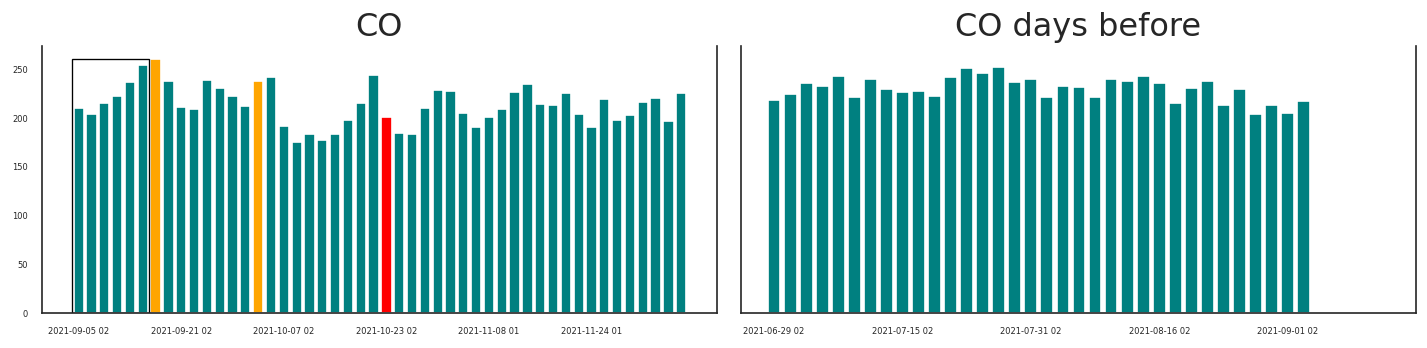

In [ ]:
anomalies_CO_l= show_data_thresh[(data_thresh['Predictions_CO'] == 1)]
anomalies_CO_m= show_data_thresh[(data_thresh['Predictions_CO'] == 2)]
anomalies_CO_h= show_data_thresh[(data_thresh['Predictions_CO'] == 3)]

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, sharey='row', dpi=120, figsize=(12,3))
x_ticks = np.arange(0, to_show, 8)
plt.setp(axes, xticks=x_ticks)
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_CO = show_data_thresh['CO']
      ax.bar(data_CO.index, data_CO, color='teal', linewidth=1)
      ax.set_xticks(x_ticks) 
          
      # x axis value list.
      x_number_list_l = list(anomalies_CO_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_CO_l['CO'].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_l, y_number_list_l, color='green', linewidth=1)

      # x axis value list.
      x_number_list_m = list(anomalies_CO_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_CO_m['CO'].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_m, y_number_list_m, color='orange', linewidth=1)

      # x axis value list.
      x_number_list_h = list(anomalies_CO_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_CO_h['CO'].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_h, y_number_list_h, color='red', linewidth=1)
      left, bottom, width, height = (-0.5, 0, 1*selected_lag_eucl, int(max(show_data_thresh['CO']+1)))
      ax.add_patch(matplotlib.patches.Rectangle((left,bottom), width, height,fill= None,
                        alpha=1, color="black"))


      # Decorations
      ax.set_title('CO')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)
    else:
      data_before = day_before['CO']
      ax.bar(data_before.index, data_before, color='teal', linewidth=1)
      ax.set_xticks(x_ticks) 
      # Decorations
      ax.set_title('CO days before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)

plt.tight_layout();

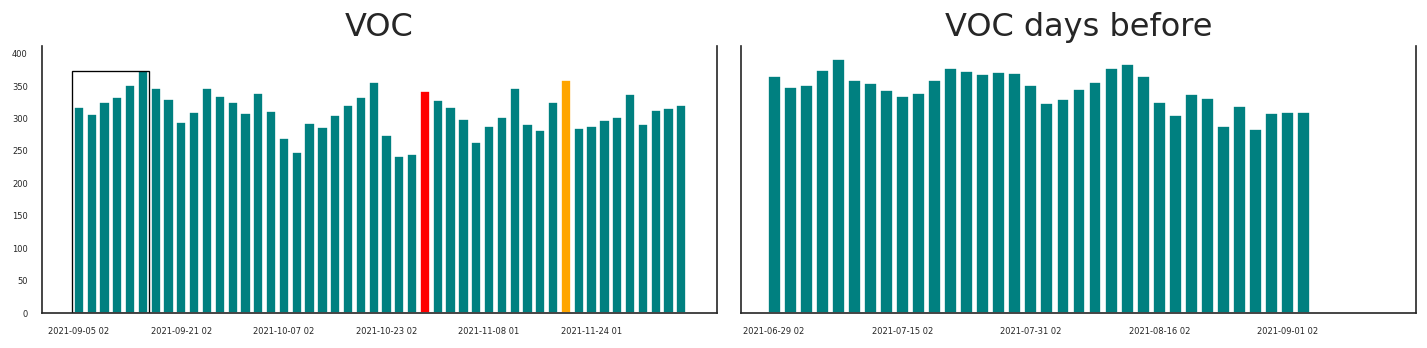

In [ ]:
anomalies_VOC_l= show_data_thresh[(data_thresh['Predictions_VOC'] == 1)]
anomalies_VOC_m= show_data_thresh[(data_thresh['Predictions_VOC'] == 2)]
anomalies_VOC_h= show_data_thresh[(data_thresh['Predictions_VOC'] == 3)]

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, sharey='row', dpi=120, figsize=(12,3))
x_ticks = np.arange(0, to_show, 8)
plt.setp(axes, xticks=x_ticks)
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_VOC = show_data_thresh['VOC']
      ax.bar(data_VOC.index, data_VOC, color='teal', linewidth=1)
      ax.set_xticks(x_ticks) 
          
      # x axis value list.
      x_number_list_l = list(anomalies_VOC_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_VOC_l['VOC'].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_l, y_number_list_l, color='green', linewidth=1)

      # x axis value list.
      x_number_list_m = list(anomalies_VOC_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_VOC_m['VOC'].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_m, y_number_list_m, color='orange', linewidth=1)

      # x axis value list.
      x_number_list_h = list(anomalies_VOC_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_VOC_h['VOC'].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_h, y_number_list_h, color='red', linewidth=1)
      left, bottom, width, height = (-0.5, 0, 1*selected_lag_eucl, int(max(show_data_thresh['VOC']+1)))
      ax.add_patch(matplotlib.patches.Rectangle((left,bottom), width, height,fill= None,
                        alpha=1, color="black"))

      # Decorations
      ax.set_title('VOC')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)
    else:
      data_before = day_before['VOC']
      ax.bar(data_before.index, data_before, color='teal', linewidth=1)
      ax.set_xticks(x_ticks) 
      # Decorations
      ax.set_title('VOC days before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)

plt.tight_layout();